# DSCI 408 Final Project
## Predicting Diabetes Risk
### Srivathsav Arumugam

#

## Importing Libraries

In [4]:
import numpy as np                     
import pandas as pd                   
import matplotlib.pyplot as plt       

# Scikit-learn tools
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression        
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler         
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

## Data Preprocessing

In [6]:
df = pd.read_csv('diabetes_dataset.csv')
df = df.sample(frac=1, random_state=1)
print("Dataset shape:", df.shape)
df.head()

# this data is currently imbalanced.

Dataset shape: (10000, 21)


,Unnamed: 0,Age,Sex,Ethnicity,BMI,Waist_Circumference,Fasting_Blood_Glucose,HbA1c,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,...,Cholesterol_HDL,Cholesterol_LDL,GGT,Serum_Urate,Physical_Activity_Level,Dietary_Intake_Calories,Alcohol_Consumption,Smoking_Status,Family_History_of_Diabetes,Previous_Gestational_Diabetes
9953,9953,48,Male,Asian,24.5,81.2,139.2,9.0,178,71,...,39.5,135.4,19.6,4.6,Low,2218,NaN,Current,1,1
3850,3850,65,Male,White,32.3,85.6,147.2,12.4,116,72,...,37.5,116.9,37.6,3.3,High,1656,Heavy,Never,1,1
4962,4962,55,Female,Hispanic,36.4,104.9,78.7,6.7,161,91,...,38.5,176.3,48.1,7.4,High,2279,NaN,Never,1,1
3886,3886,36,Female,White,21.3,93.4,184.9,7.9,174,65,...,40.5,165.2,34.8,3.7,High,2928,Heavy,Current,1,1
5437,5437,36,Female,White,22.4,110.1,125.2,12.5,133,78,...,65.5,150.3,33.4,5.5,Moderate,1888,NaN,Former,0,1


#### If HbA1c is greater than or equal to 6.5 OR Fasting_Blood_Glucose is greater than or equal to 126, the person is classified as diabetic (1). Otherwise, the person is classified as non-Diabteic(0)

##### A new column 'Diabetes' is created for my target

In [8]:

# HbA1c >= 6.5% or Fasting Blood Glucose >= 126 mg/dL indicates diabetes
df['Diabetes'] = ((df['HbA1c'] >= 6.5) | (df['Fasting_Blood_Glucose'] >= 126)).astype(int)
print("Diabetes distribution:")
print(df['Diabetes'].value_counts())
print(f"Percentage with diabetes: {df['Diabetes'].mean()*100:.2f}%")
# The distribution of the Diabetes column is displayed using value_counts() and the percentage of people with diabetes is calculated.

Diabetes distribution:
Diabetes
1    9047
0     953
Name: count, dtype: int64
Percentage with diabetes: 90.47%


In [9]:
print(df.dtypes)

Unnamed: 0                         int64
Age                                int64
Sex                               object
Ethnicity                         object
BMI                              float64
Waist_Circumference              float64
Fasting_Blood_Glucose            float64
HbA1c                            float64
Blood_Pressure_Systolic            int64
Blood_Pressure_Diastolic           int64
Cholesterol_Total                float64
Cholesterol_HDL                  float64
Cholesterol_LDL                  float64
GGT                              float64
Serum_Urate                      float64
Physical_Activity_Level           object
Dietary_Intake_Calories            int64
Alcohol_Consumption               object
Smoking_Status                    object
Family_History_of_Diabetes         int64
Previous_Gestational_Diabetes      int64
Diabetes                           int32
dtype: object


In [10]:
cat_columns = ['Sex', 'Ethnicity', 'Physical_Activity_Level', 
                       'Alcohol_Consumption', 'Smoking_Status']
cat_data = df[cat_columns]

encoder = OneHotEncoder(sparse_output=False, drop='first')#drop='first means that for each categorical feature, the encoder will omit the first category
encoded_data = encoder.fit_transform(cat_data)

feature_names = encoder.get_feature_names_out(cat_columns)
encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=df.index)

non_cat_data = df.drop(cat_columns, axis=1)
df_encoded = pd.concat([non_cat_data, encoded_df], axis=1)

#The target column (Diabetes) is separated from the features.
#Features are stored in X, and the target is stored in y:
X = df_encoded.drop(['Diabetes'], axis=1)
y = df_encoded['Diabetes']

# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (7500, 26)
Testing set shape: (2500, 26)


In [11]:
## Scaling to enusre everything is on ethe same scale, I will be using logistic regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating a logistic regression model
# The dataset im using is heavily imbalanced, there are way more diabetes cases than non-diabtetes cases. This makes the model focus on the majority class, making it result in less performance for the minority.(Bias)
# the model tends to predict the majority class more often because it minimizes the overall error. This results in poor recall and F1-score for the minority class.
#class_weight='balanced' parameter tells the model to give more importance to the minority class (non-diabetes) during training.
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [12]:
# Model performance
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9464
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.97      0.76       223
           1       1.00      0.94      0.97      2277

    accuracy                           0.95      2500
   macro avg       0.81      0.96      0.87      2500
weighted avg       0.96      0.95      0.95      2500

Confusion Matrix:
 [[ 216    7]
 [ 127 2150]]


## Random Forest Model

In [36]:
# Random forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42) # I set random state for reproducing the results.
rf_model.fit(X_train, y_train) # training model with training data

RandomForestClassifier(class_weight='balanced', random_state=42)

In [14]:
# model testinf
y_pred_rf = rf_model.predict(X_test) ## Using the trained model to make predictions on the test data (X_test)
## Calculate and print the accuracy of the model by comparing the predicted values (y_pred_rf) with the actual test labels (y_test)
print("Random forest accuracy rate:", accuracy_score(y_test, y_pred_rf)) 
print("Random forest classification Rrport:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix report:\n", confusion_matrix(y_test, y_pred_rf))

Random forest accuracy rate: 0.9996
Random forest classification Rrport:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00      2277

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

Random Forest Confusion Matrix report:
 [[ 222    1]
 [   0 2277]]


In [ ]:
# Tuning the random forest performance through hyperparameter tuning as well as 5 fold cross validation

In [15]:
## Starting the Random Forest Classifier with specific hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100, ## controls how many descision trees the random forest will build. The predictions are averaged so it will reduce variance and improve performance. 
    max_depth=None, ##limits how deep a tree can grow
    min_samples_split=2, ## controls the amount of samples in order to split a node into 2
    min_samples_leaf = 1, ## sets the minimum number of samples that are required to be at a leaf node. 
    class_weight='balanced', # Handling the class imbalance
    random_state=42        
)
rf_model.fit(X_train, y_train)

cv_scores = cross_val_score(
    rf_model,  
    X_train,   ## Training features
    y_train,   # Training target
    cv=5,      # the Number of folds
    scoring='accuracy' 
)

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

#y_pred_rf = rf_model.predict(X_test)
#print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
#print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
#print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Cross-Validation Scores: [1.         1.         1.         1.         0.99933333]
Mean Accuracy: 0.9998666666666667
Standard Deviation: 0.0002666666666666817


## Feature Importance

                             Feature  Importance
5                              HbA1c    0.630343
4              Fasting_Blood_Glucose    0.295218
8                  Cholesterol_Total    0.006551
9                    Cholesterol_HDL    0.006462
0                         Unnamed: 0    0.006141
11                               GGT    0.005928
1                                Age    0.005854
2                                BMI    0.005491
13           Dietary_Intake_Calories    0.005479
6            Blood_Pressure_Systolic    0.005441
12                       Serum_Urate    0.005286
3                Waist_Circumference    0.005211
7           Blood_Pressure_Diastolic    0.005014
10                   Cholesterol_LDL    0.004993
15     Previous_Gestational_Diabetes    0.000733
20       Physical_Activity_Level_Low    0.000717
19                   Ethnicity_White    0.000592
16                          Sex_Male    0.000578
17                   Ethnicity_Black    0.000542
22      Alcohol_Cons

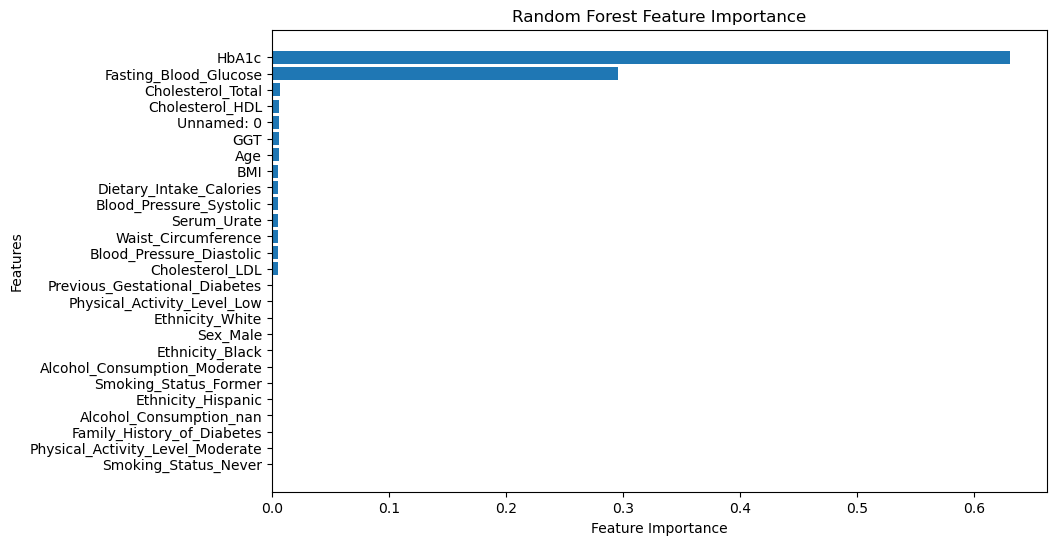

In [16]:
## Feature importance. 

feature_imp = rf_model.feature_importances_

#DF creation
imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance':feature_imp
}).sort_values(by='Importance', ascending=False)

print(imp_df)

plt.figure(figsize=(10, 6))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis() 
plt.show()

## Confusion Matrix

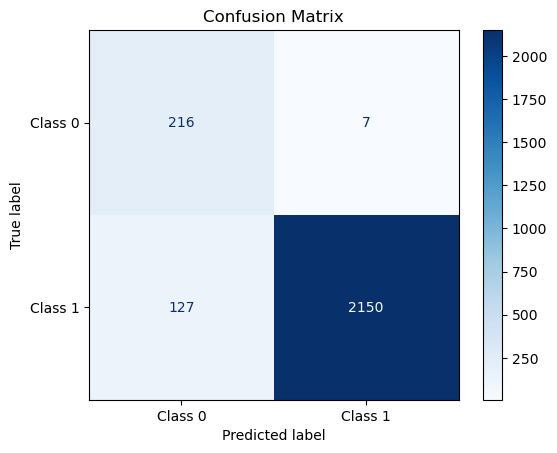

In [17]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## ROC curve

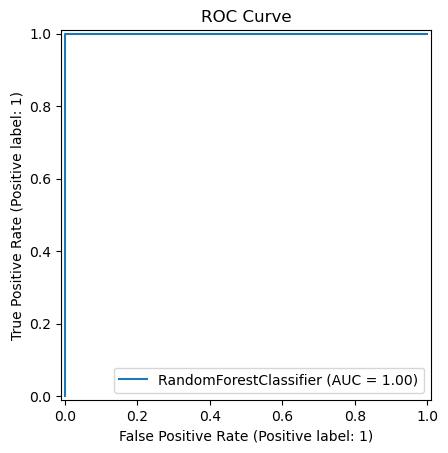

In [18]:
#ROC curve
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()